# Leaf-tree as a filtration

PLSCAN's leaf-tree is similar to barcodes produced by persistent homology. The
leaf tree describes leaf-cluster lifetimes for the minimum cluster size
parameter. This notebook explores how the same lifetimes can be found using
persistent homology.

One of the difficulties is that leaf-clusters can end before their parent's
birth. What should happen to those points in a filtration? For example, see the
left-most leaf-cluster in this leaf tree:

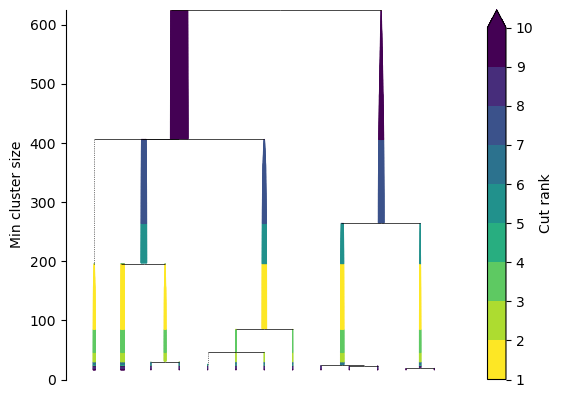

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from gtda.homology import VietorisRipsPersistence, FlagserPersistence

from plscan import PLSCAN

warnings.filterwarnings("ignore", category=FutureWarning)
data = np.load("data/clusterable/sources/clusterable_data.npy")

mc = 15
n = data.shape[0]
c = PLSCAN(min_samples=mc).fit(data)
c.leaf_tree_.plot()
plt.show()

In [2]:
c._leaf_tree.parent[np.flatnonzero(c._leaf_tree.max_size == 26)]

array([18, 18], dtype=uint32)

In [3]:
from plscan._api import compute_cluster_labels

l, p = compute_cluster_labels(c._leaf_tree, c._condensed_tree, np.array([18]).astype(np.uint32), n)
i = np.where(l >= 0)[0]

To start, we define a distance metric measuring the lowest minimum cluster size
for which two points belong to the same leaf cluster. We compute a distance
matrix for this metric by evaluating cluster labels at all topology changing
size thresholds in decreasing order. Points in the same cluster get the current
threshold as distance.

In [4]:
dists = np.full((n, n), np.inf)
for size in c._persistence_trace.min_size[::-1]:
    labels, probs = c.min_cluster_size_cut(size)
    for i in range(0, labels.max() + 1):
        pts = np.flatnonzero(labels == i)
        X, Y = np.meshgrid(pts, pts)
        dists[X, Y] = size

The resulting matrix has a minimum value of $m_{\rm c}$. We subtract $m_{\rm
c}$, so the lowest possible distance becomes zero.

In [5]:
dists -= mc

The matrix has a non-zero diagonal, because points set the first size at which
they are in a leaf cluster as their self-distance. That distance can be larger
than $m_{\rm c}$! To fix this, we set the diagonal to zero manually.

In [6]:
np.fill_diagonal(dists, 0)

The resulting distance matrix has infinite values because PLSCAN never returns a
single leaf-cluster.

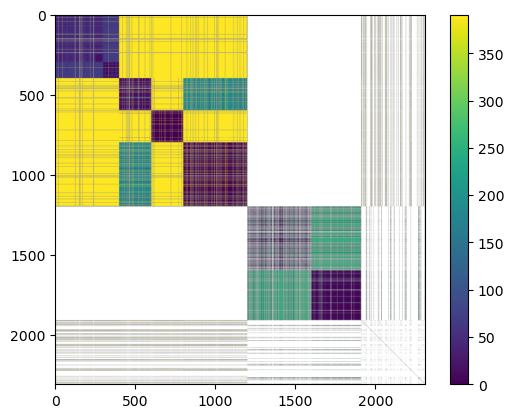

In [7]:
plt.imshow(dists)
plt.colorbar()
plt.show()

We can now compute zero-dimensional persistent homology with Vietoris--Rips
complexes. The resulting barcode has a rows for each connected component and a
column for the birth value, death value, and feature dimension.

In [8]:
bars = VietorisRipsPersistence(
    homology_dimensions=[0], reduced_homology=False, metric="precomputed"
).fit_transform([dists])[0]
bars.shape

(1270, 3)

We are only interested in the death values, because every point enters the
filtration at $0$.

In [9]:
np.unique(bars[:, 1]) + mc

array([ 19.,  23.,  24.,  30.,  46.,  85., 196., 264., 406.,  inf])

The barcode we uncovered almost matches the leaf tree. It misses the
leaf-cluster death at $26$, which corresponds to a leaf-cluster that ends before
its parent birth. The infinite barcode value corresponds to the $625$ and $n$
entries in the leaf tree.

In [10]:
np.unique(c._leaf_tree.max_size.astype(int)[c._leaf_tree.min_size < c._leaf_tree.max_size])

array([  19,   23,   24,   26,   30,   46,   85,  196,  264,  406,  625,
       2309])

## Detecting noise-deaths

To detect leaf-clusters that die before their parent is born, we can look at
points' lowest threshold for which they are not part of any leaf clusters. In
our implementation, this are all points with the noise label (-1). Suppose we
add an extra element for each data point in the filtration and set the distance
from a point to its extra element to the first threshold at which it is a noise
point. Then, early leaf-deaths are encoded as a point connecting to its noise
flag element. The additional elements do not get any other edges, so do not
contribute connectivity to connected components in the filtration.

In [11]:
dists = np.full((2*n, 2*n), np.inf)
for size in c._persistence_trace.min_size[::-1]:
    labels, probs = c.min_cluster_size_cut(size)
    noise_pts = np.flatnonzero(labels == -1)
    dists[noise_pts, noise_pts + n] = size
    dists[noise_pts + n, noise_pts] = size
    for i in range(0, labels.max() + 1):
        pts = np.flatnonzero(labels == i) + n
        X, Y = np.meshgrid(pts, pts)
        dists[X, Y] = size

np.fill_diagonal(dists[:n, :n], 0) # Definition of self-distances

The resulting matrix has twice the number of points. The first half act as
noise-flags. Points connect to their noise flags on the lowest threshold for
which they are not in any leaf. The noise flags do not connect to anything
themselves.

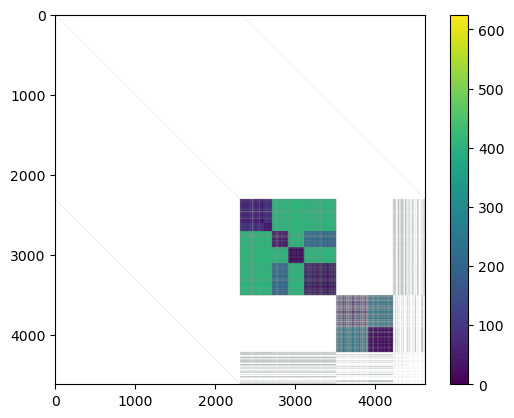

In [12]:
plt.imshow(dists)
plt.colorbar()
plt.show()

The resulting barcode now correctly recover all death sizes!

In [13]:
bars = VietorisRipsPersistence(
    homology_dimensions=[0], reduced_homology=False, metric="precomputed"
).fit_transform([dists])[0]
deaths, counts = np.unique(bars[:, 1], return_counts=True)
deaths, counts

(array([ 19.,  23.,  24.,  26.,  30.,  46.,  85., 196., 264., 406., 625.,
         inf]),
 array([210,  49,  95,  26, 133,  85, 111, 201,  51,  61, 830, 470]))